# EDA

## Intro

In [2]:
%reload_ext autoreload
%autoreload 1
import joblib
import numpy as np
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report
import auxiliary.lists as aux_lists
import auxiliary.transformers as tr
import auxiliary.eda_functions as eda
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from IPython.display import Markdown,display
import matplotlib.ticker as ticker
from tabulate import tabulate
%aimport auxiliary.lists
%aimport auxiliary.transformers
%aimport auxiliary.eda_functions


In [3]:
sns.set()
BASE_FIG_SIZE=(8.5,4.5)

In [4]:
# applicattion_test=pl.read_csv('data/application_test.csv')
application_train=pl.read_csv('data/application_train.csv')
bureau_balance=pl.read_csv('data/bureau_balance.csv')
bureau=pl.read_csv('data/bureau.csv')
installments_payments=pl.read_csv('data/installments_payments.csv')
POS_CASH_balance=pl.read_csv('data/POS_CASH_balance.csv')
previous_application=pl.read_csv('data/previous_application.csv')
credit_card_balance=pl.read_csv('data/credit_card_balance.csv')
id_and_target=["SK_ID_CURR", "TARGET"]

## Data Integrity

In [5]:
application_train.head()

SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,…,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
i64,i64,str,str,str,str,i64,f64,f64,f64,f64,str,str,str,str,str,f64,i64,i64,f64,i64,f64,i64,i64,i64,i64,i64,i64,str,f64,i64,i64,str,i64,i64,i64,i64,…,f64,str,str,f64,str,str,f64,f64,f64,f64,f64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,f64,f64,f64,f64,f64,f64
100002,1,"""Cash loans""","""M""","""N""","""Y""",0,202500.0,406597.5,24700.5,351000.0,"""Unaccompanied""","""Working""","""Secondary / se…","""Single / not m…","""House / apartm…",0.018801,-9461,-637,-3648.0,-2120,null,1,1,0,1,1,0,"""Laborers""",1.0,2,2,"""WEDNESDAY""",10,0,0,0,…,0.0,"""reg oper accou…","""block of flats…",0.0149,"""Stone, brick""","""No""",2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
100003,0,"""Cash loans""","""F""","""N""","""N""",0,270000.0,1293502.5,35698.5,1.1295e6,"""Family""","""State servant""","""Higher educati…","""Married""","""House / apartm…",0.003541,-16765,-1188,-1186.0,-291,null,1,1,0,1,1,0,"""Core staff""",2.0,1,1,"""MONDAY""",11,0,0,0,…,0.01,"""reg oper accou…","""block of flats…",0.0714,"""Block""","""No""",1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
100004,0,"""Revolving loan…","""M""","""Y""","""Y""",0,67500.0,135000.0,6750.0,135000.0,"""Unaccompanied""","""Working""","""Secondary / se…","""Single / not m…","""House / apartm…",0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,"""Laborers""",1.0,2,2,"""MONDAY""",9,0,0,0,…,null,null,null,null,null,null,0.0,0.0,0.0,0.0,-815.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
100006,0,"""Cash loans""","""F""","""N""","""Y""",0,135000.0,312682.5,29686.5,297000.0,"""Unaccompanied""","""Working""","""Secondary / se…","""Civil marriage…","""House / apartm…",0.008019,-19005,-3039,-9833.0,-2437,null,1,1,0,1,0,0,"""Laborers""",2.0,2,2,"""WEDNESDAY""",17,0,0,0,…,null,null,null,null,null,null,2.0,0.0,2.0,0.0,-617.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,null,null,null,null,null,null
100007,0,"""Cash loans""","""M""","""N""","""Y""",0,121500.0,513000.0,21865.5,513000.0,"""Unaccompanied""","""Working""","""Secondary / se…","""Single / not m…","""House / apartm…",0.028663,-19932,-3038,-4311.0,-3458,null,1,1,0,1,0,0,"""Core staff""",1.0,2,2,"""THURSDAY""",11,0,0,0,…,null,null,null,null,null,null,0.0,0.0,0.0,0.0,-1106.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


#### Duplicates

In [6]:
application_train['SK_ID_CURR'].is_duplicated().any()

False

#### Missing Values


**Missing value graphical overview:**

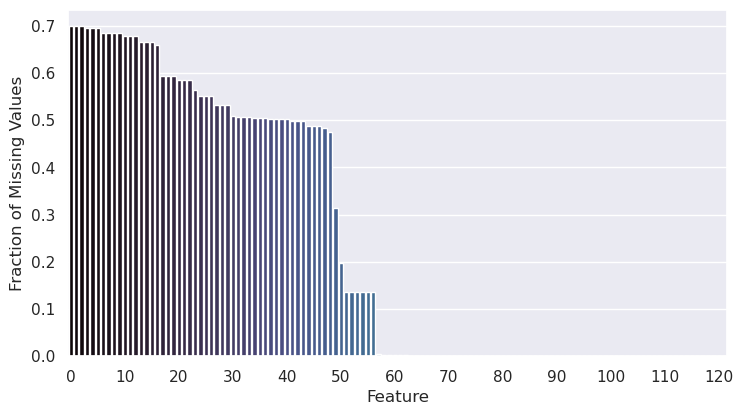

In [7]:
missing_values_main = pl.DataFrame(
    {
        "missing_fraction": application_train.null_count().transpose().to_series()
        / len(application_train),
        "feature": application_train.columns,
    }
).sort("missing_fraction", descending=True)

fig_main_missing, ax_main_missing = plt.subplots(figsize=BASE_FIG_SIZE)
sns.barplot(
    x=missing_values_main["feature"].to_numpy(),
    y=missing_values_main["missing_fraction"].to_numpy(),
    hue=missing_values_main["feature"].to_numpy(),
    legend=False,
    ax=ax_main_missing,
    palette=sns.color_palette('mako',n_colors=len(missing_values_main))
)
ax_main_missing.set_xticks(np.arange(len(missing_values_main), step=10))
ax_main_missing.set_xticklabels(np.arange(len(missing_values_main), step=10))
ax_main_missing.set_xlabel("Feature")
ax_main_missing.set_ylabel("Fraction of Missing Values")
plt.show()

**Features with most missing values:**

In [8]:
missing_values_main[:10]

missing_fraction,feature
f64,str
0.698723,"""COMMONAREA_AVG…"
0.698723,"""COMMONAREA_MOD…"
0.698723,"""COMMONAREA_MED…"
0.69433,"""NONLIVINGAPART…"
0.69433,"""NONLIVINGAPART…"
0.69433,"""NONLIVINGAPART…"
0.683862,"""FONDKAPREMONT_…"
0.68355,"""LIVINGAPARTMEN…"
0.68355,"""LIVINGAPARTMEN…"


#### References in other tables:

**Percentage of users with reference in other tables:**

In [9]:
tables_with_reference = {
    "Bureau": bureau,
    "Positive Cash Balance": POS_CASH_balance,
    "Credit Card Balance": credit_card_balance,
    "Previous Application": previous_application,
    "Installments Payments": installments_payments,
}

for name, table in tables_with_reference.items():
    frac_with_reference = len(
        application_train.filter(pl.col("SK_ID_CURR").is_in(table["SK_ID_CURR"]))
    ) / len(application_train)
    display(
        Markdown(
            f"{round(frac_with_reference*100)}% of users have reference in {name} table."
        )
    )

86% of users have reference in Bureau table.

94% of users have reference in Positive Cash Balance table.

28% of users have reference in Credit Card Balance table.

95% of users have reference in Previous Application table.

95% of users have reference in Installments Payments table.

**Number of references per user:**

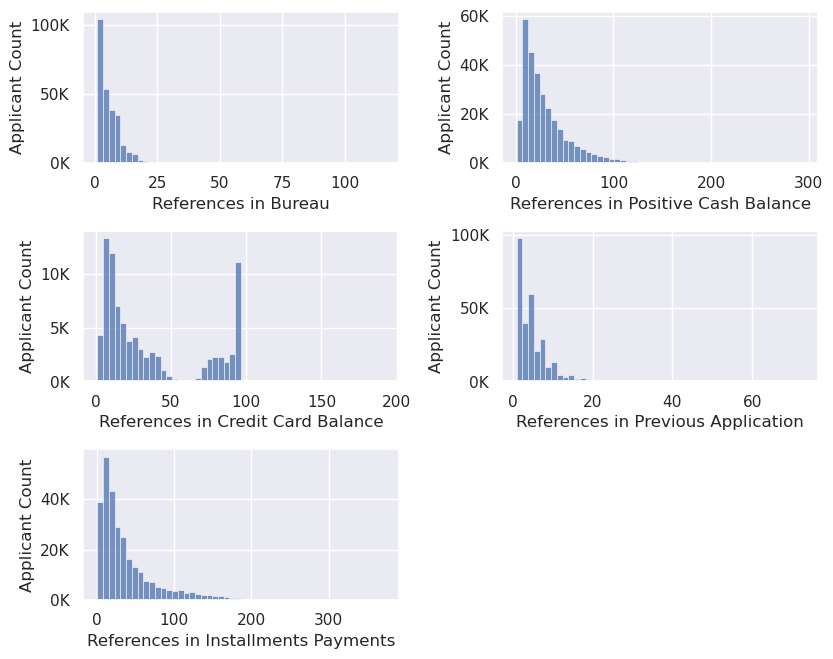

In [10]:
fig_reference_counts, ax_reference_counts = plt.subplots(
    3, 2, figsize=(BASE_FIG_SIZE[0], BASE_FIG_SIZE[1] * 1.5)
)
ax_reference_counts = ax_reference_counts.flatten()

for i, (name, table) in enumerate(tables_with_reference.items()):
    count_table = table.filter(
        pl.col("SK_ID_CURR").is_in(application_train["SK_ID_CURR"])
    )["SK_ID_CURR"].value_counts()

    sns.histplot(count_table["counts"], ax=ax_reference_counts[i],bins=50)
    # ax_reference_counts[i].set_title(name)
    ax_reference_counts[i].set_xlabel(f"References in {name}")
    ax_reference_counts[i].set_ylabel('Applicant Count')
    ax_reference_counts[i].yaxis.set_major_formatter(
        ticker.FuncFormatter(lambda x, pos: "{:,g}".format(x / 1000) + "K")
    )
plt.delaxes(ax_reference_counts[-1])
plt.tight_layout()
plt.show()

In [11]:
initial_test = eda.test_with_catboost_crossval(
    X=application_train.drop(columns=id_and_target),
    y=application_train["TARGET"],
    sample_size=50000,
)

In [12]:
eda.table_display(initial_test["features"][:20])

| feature                    |   importance |
|:---------------------------|-------------:|
| EXT_SOURCE_3               |      9.49508 |
| EXT_SOURCE_2               |      8.94928 |
| EXT_SOURCE_1               |      5.76733 |
| DAYS_BIRTH                 |      5.26519 |
| AMT_CREDIT                 |      4.33955 |
| AMT_ANNUITY                |      3.99456 |
| DAYS_ID_PUBLISH            |      3.91373 |
| DAYS_EMPLOYED              |      3.47728 |
| DAYS_LAST_PHONE_CHANGE     |      3.47288 |
| AMT_GOODS_PRICE            |      3.23805 |
| DAYS_REGISTRATION          |      2.7918  |
| REGION_POPULATION_RELATIVE |      2.09828 |
| AMT_INCOME_TOTAL           |      2.03654 |
| HOUR_APPR_PROCESS_START    |      1.76779 |
| OCCUPATION_TYPE            |      1.7285  |
| NAME_EDUCATION_TYPE        |      1.68306 |
| AMT_REQ_CREDIT_BUREAU_YEAR |      1.4442  |
| NAME_FAMILY_STATUS         |      1.29938 |
| CODE_GENDER                |      1.26547 |
| NAME_INCOME_TYPE           |      1.25644 |

### Cats

In [13]:
application_cat_cols=application_train.select(pl.col(pl.Utf8)).columns

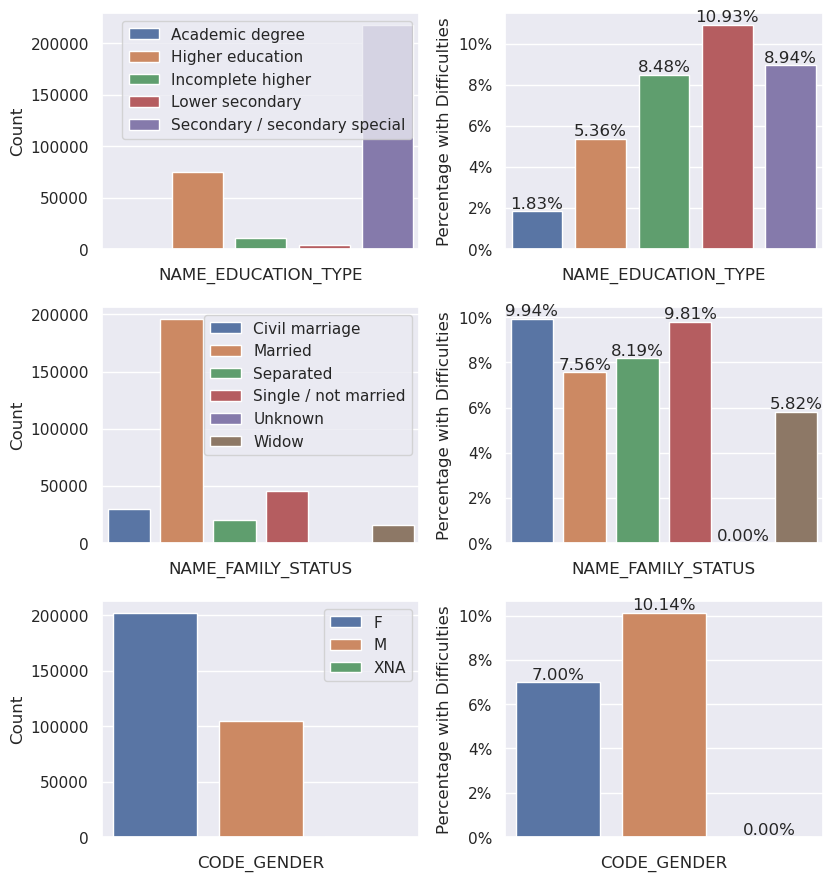

In [14]:
interesting_features = [
    feature
    for feature in initial_test["features"][:20, 0].to_list()
    if feature in application_cat_cols
]
many_cats = ["OCCUPATION_TYPE", "NAME_INCOME_TYPE"]
interesting_features = [i for i in interesting_features if i not in many_cats]

fig_main_cats, ax_main_cats = plt.subplots(
    3, 2, figsize=(BASE_FIG_SIZE[0], BASE_FIG_SIZE[1] * 2)
)
for i, col in enumerate(interesting_features):
    sns.countplot(
        x=application_train.sort(col)[col].to_numpy(),
        hue=application_train.sort(col)[col].to_numpy(),
        ax=ax_main_cats[i, 0],
        legend=True,
    )
    agg_df = (
        application_train[[col, "TARGET"]]
        .group_by(col)
        .agg(pl.col("TARGET").sum().alias("TARGET"), pl.all().count().alias("count"))
        .with_columns((pl.col("TARGET") / pl.col("count")).alias("frac") * 100)
    ).sort(col)

    sns.barplot(
        x=agg_df.sort(col)[col].to_numpy(),
        y=agg_df.sort(col)["frac"].to_numpy(),
        hue=agg_df[col].to_numpy(),
        ax=ax_main_cats[i, 1],
        legend=False,
    )

    ax_main_cats[i, 0].set_xticklabels([])
    ax_main_cats[i, 1].set_xticklabels([])
    ax_main_cats[i, 0].set_xlabel(col)
    ax_main_cats[i, 1].set_xlabel(col)
    for container in ax_main_cats[i, 1].containers:
        ax_main_cats[i, 1].bar_label(container, fmt="%.2f%%", label_type="edge")
    sns.move_legend(ax_main_cats[i, 0], "upper right")
    ax_main_cats[i, 1].yaxis.set_major_formatter(ticker.PercentFormatter(decimals=0))
    ax_main_cats[i, 0].set_ylabel("Count")
    ax_main_cats[i, 1].set_ylabel("Percentage with Difficulties")
plt.tight_layout()
plt.show()

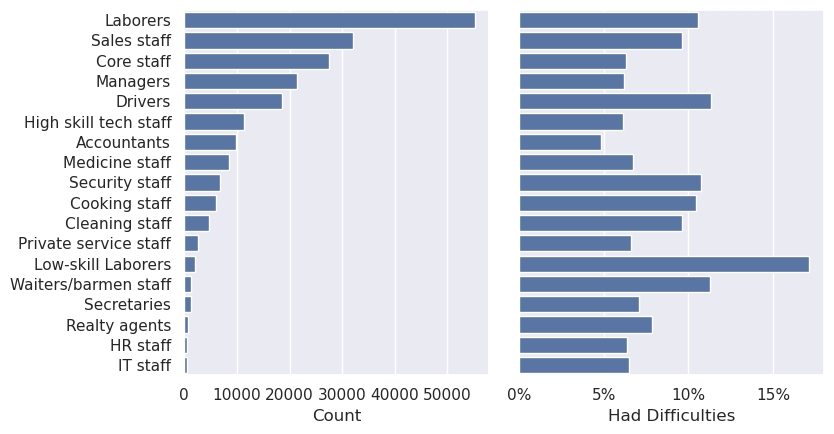

In [15]:
occupation_df = (
    application_train.group_by("OCCUPATION_TYPE")
    .agg(pl.count(), pl.col("TARGET").sum())
    .with_columns((pl.col("TARGET")*100 / pl.col("count")).alias("Frac With Difficulties"))
    .sort("count", descending=True)
)

fig_occ, ax_occ = plt.subplots(1, 2, figsize=BASE_FIG_SIZE,sharey=True)
sns.barplot(
    y=occupation_df["OCCUPATION_TYPE"].to_numpy(),
    x=occupation_df["count"].to_numpy(),
    ax=ax_occ[0],
)
ax_occ[0].set_xlabel('Count')

sns.barplot(
    y=occupation_df["OCCUPATION_TYPE"].to_numpy(),
    x=occupation_df["Frac With Difficulties"].to_numpy(),
    ax=ax_occ[1],
)
ax_occ[1].set_xlabel('Had Difficulties')
ax_occ[1].xaxis.set_major_formatter(ticker.PercentFormatter(decimals=0))

plt.tight_layout()
plt.show()

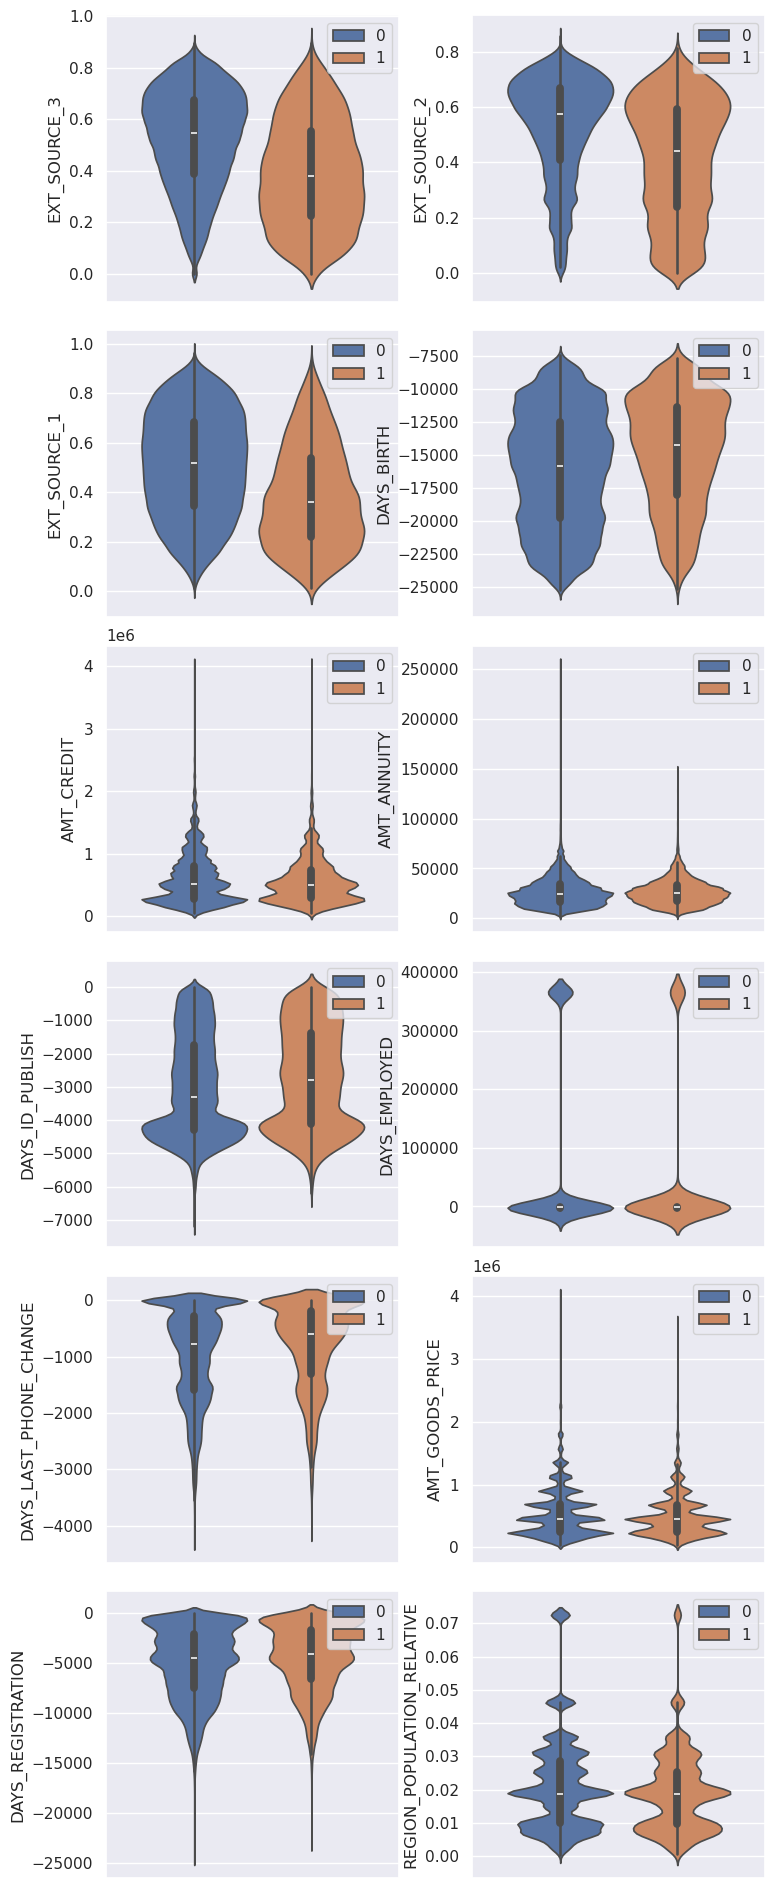

In [16]:
interesting_num_features = [
    i for i in initial_test["features"][:12, 0] if i not in application_cat_cols
]
fig_num_box, ax_num_box = plt.subplots(
    6, 2, figsize=(BASE_FIG_SIZE[0], BASE_FIG_SIZE[1] * 3)
)
ax_num_box = ax_num_box.flatten()

for i, col in enumerate(interesting_num_features):
    sns.violinplot(
        y=application_train[col].to_numpy(),
        hue=application_train["TARGET"].to_numpy(),
        ax=ax_num_box[i],
        gap=0.1
    )
    ax_num_box[i].set_ylabel(col)
plt.subplots_adjust(bottom=-0.5,wspace=0.25,hspace=0.1)
plt.show()

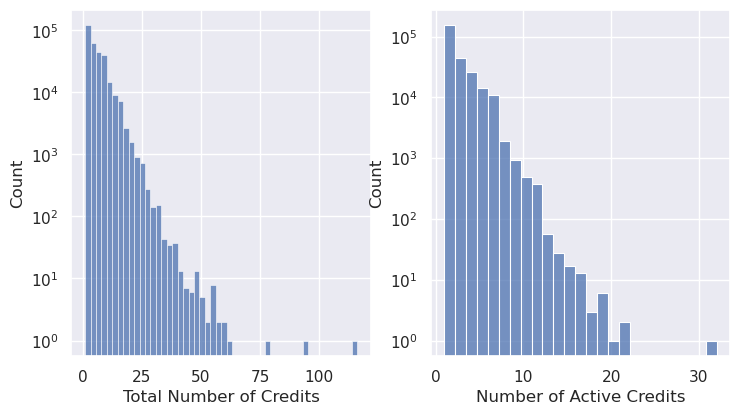

In [17]:
fig_bureau_entries, ax_bureau_entries = plt.subplots(1, 2, figsize=BASE_FIG_SIZE)
sns.histplot(
    bureau.group_by("SK_ID_CURR").agg(pl.count())["count"],
    bins=50,
    ax=ax_bureau_entries[0],
)
ax_bureau_entries[0].set_xlabel("Total Number of Credits")
ax_bureau_entries[0].set_yscale("log")
sns.histplot(
    bureau.filter(pl.col("CREDIT_ACTIVE") == "Active")
    .group_by("SK_ID_CURR")
    .agg(pl.count())["count"],
    bins=25,
    ax=ax_bureau_entries[1],
)
ax_bureau_entries[1].set_yscale("log")
ax_bureau_entries[1].set_xlabel("Number of Active Credits")
plt.show()

In [18]:
bureau.select((pl.col('CREDIT_ACTIVE')=="Active") & (pl.col("CREDIT_DAY_OVERDUE")>0)).sum()

CREDIT_ACTIVE
u32
4044


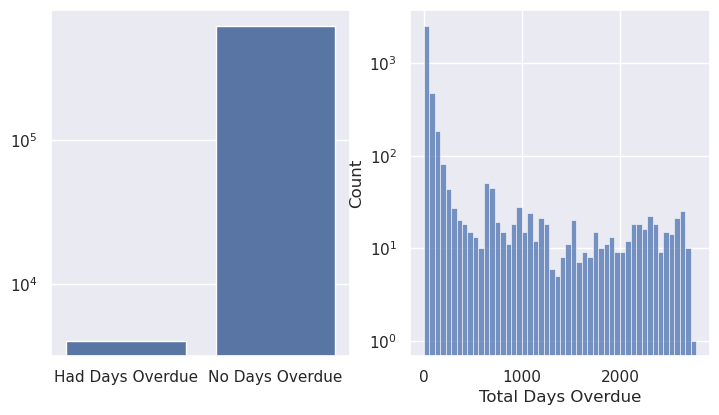

In [19]:
fig_days_over_bur,ax_days_over_bur=plt.subplots(1,2,figsize=BASE_FIG_SIZE)
sns.barplot(
    [
        (
            bureau.filter((pl.col("CREDIT_ACTIVE") == "Active"))["CREDIT_DAY_OVERDUE"]
            != 0
        ).sum(),
        (
            bureau.filter((pl.col("CREDIT_ACTIVE") == "Active"))["CREDIT_DAY_OVERDUE"]
            == 0
        ).sum(),
    ],
    ax=ax_days_over_bur[0]
)
ax_days_over_bur[0].set_yscale("log")
ax_days_over_bur[0].set_xticks([0,1])
ax_days_over_bur[0].set_xticklabels(['Had Days Overdue','No Days Overdue'])
sns.histplot(
    bureau.filter(
        (pl.col("CREDIT_ACTIVE") == "Active") & (pl.col("CREDIT_DAY_OVERDUE") > 0)
    )["CREDIT_DAY_OVERDUE"],
    bins=50,
    ax=ax_days_over_bur[1]
)
ax_days_over_bur[1].set_xlabel("Total Days Overdue")
ax_days_over_bur[1].set_yscale("log")

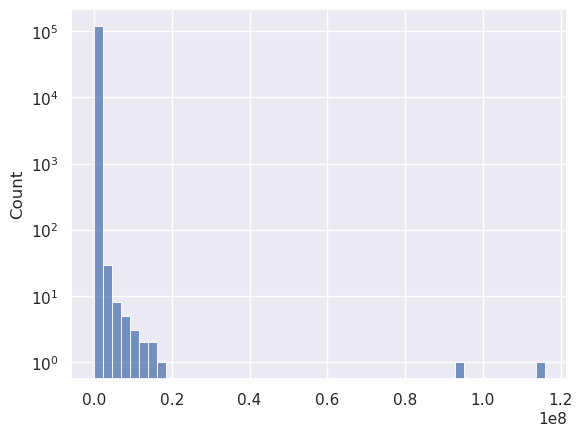

In [20]:
sns.histplot(bureau.filter(pl.col('AMT_CREDIT_MAX_OVERDUE')>0)['AMT_CREDIT_MAX_OVERDUE'],bins=50)
plt.yscale('log')


In [21]:
bureau = bureau.with_columns(
    pl.col("AMT_ANNUITY").str.to_decimal().cast(pl.Float64).alias("AMT_ANNUITY")
)

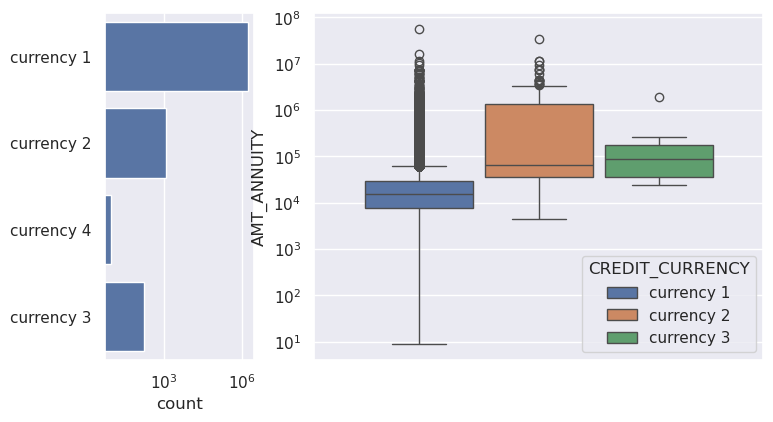

In [22]:
fig_curr, ax_curr = plt.subplots(
    1, 2, figsize=BASE_FIG_SIZE, gridspec_kw={"width_ratios": [1, 3]}
)
sns.countplot(bureau["CREDIT_CURRENCY"], ax=ax_curr[0])
ax_curr[0].set_xscale("log")
sns.boxplot(
    y=bureau[["CREDIT_CURRENCY", "AMT_ANNUITY"]]
    .drop_nulls()
    .filter(pl.col("AMT_ANNUITY") > 0)["AMT_ANNUITY"],
    hue=bureau[["CREDIT_CURRENCY", "AMT_ANNUITY"]]
    .drop_nulls()
    .filter(pl.col("AMT_ANNUITY") > 0)["CREDIT_CURRENCY"],
    gap=0.1,
    ax=ax_curr[1],
)
ax_curr[1].set_yscale("log")

Amount features with minority currencies will be removed.

Text(0.5, 0, 'Days Before Home Credit Application')

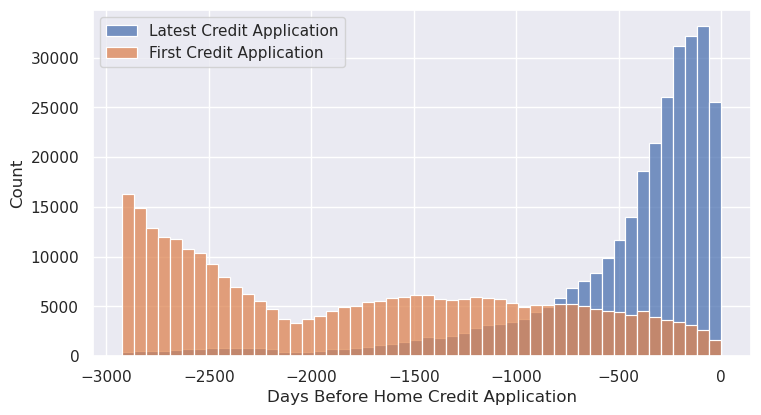

In [35]:
fig_days_bureau,ax_days_bureau=plt.subplots(figsize=BASE_FIG_SIZE)
sns.histplot(
    bureau.group_by("SK_ID_CURR").agg(pl.col("DAYS_CREDIT").max())["DAYS_CREDIT"],
    ax=ax_days_bureau,
    label='Latest Credit Application',
    bins=50
)
sns.histplot(
    bureau.group_by("SK_ID_CURR").agg(pl.col("DAYS_CREDIT").min())["DAYS_CREDIT"],
    ax=ax_days_bureau,
    label="First Credit Application",
    bins=50
)
ax_days_bureau.legend()
ax_days_bureau.set_xlabel('Days Before Home Credit Application')
plt.show()

Text(0.5, 0, 'Days to Last information about Credit')

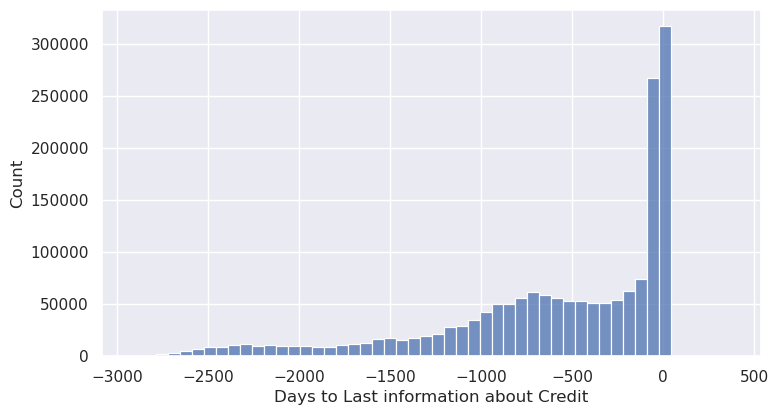

In [52]:
fig_days_update, ax_days_update = plt.subplots(figsize=BASE_FIG_SIZE)
sns.histplot(
    bureau.filter(pl.col("DAYS_CREDIT_UPDATE") > -10000)["DAYS_CREDIT_UPDATE"],
    bins=50,
    ax=ax_days_update,
)
ax_days_update.set_xlabel('Days to Last information about Credit'
)
plt.show()

Text(0.5, 1.0, 'Credit Types in Credit Bureau')

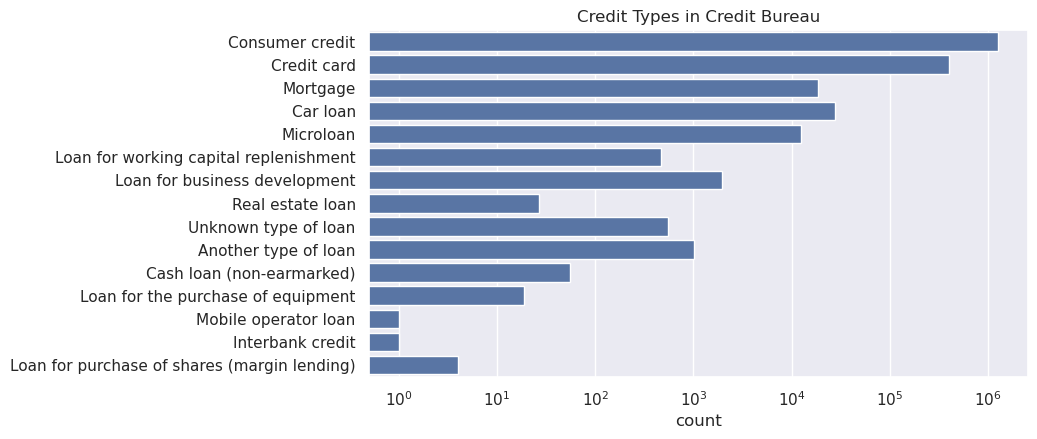

In [58]:
fig_bur_counts,ax_bur_counts=plt.subplots(figsize=BASE_FIG_SIZE)
sns.countplot(bureau['CREDIT_TYPE'],ax=ax_bur_counts)
ax_bur_counts.set_xscale('log')
ax_bur_counts.set_title('Credit Types in Credit Bureau')
plt.show()


### Previous

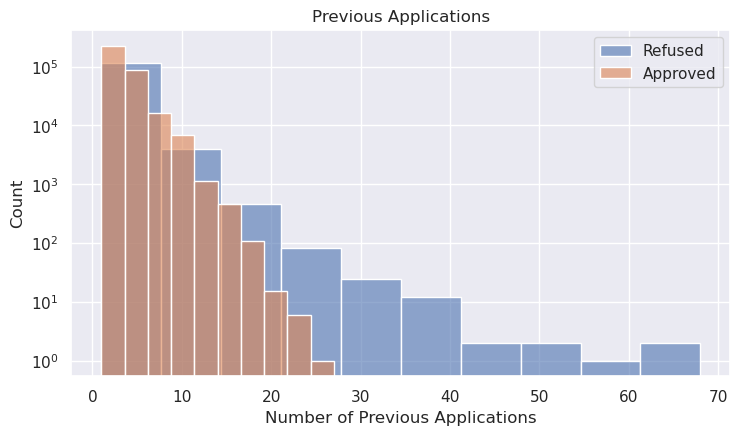

In [72]:
fig_previous_counts, ax_previous_counts = plt.subplots(1, 1, figsize=BASE_FIG_SIZE)
sns.histplot(
    previous_application.filter(pl.col("NAME_CONTRACT_STATUS") == "Refused")
    .group_by("SK_ID_CURR")
    .agg(pl.count())["count"],
    bins=10,
    ax=ax_previous_counts,
    label="Refused",
    alpha=0.6
)

sns.histplot(
    previous_application.filter(pl.col("NAME_CONTRACT_STATUS") == "Approved")
    .group_by("SK_ID_CURR")
    .agg(pl.count())["count"],
    bins=10,
    ax=ax_previous_counts,
    label='Approved',
    alpha=0.6
)

ax_previous_counts.legend()
ax_previous_counts.set_title('Previous Applications')
ax_previous_counts.set_xlabel('Number of Previous Applications')
ax_previous_counts.set_yscale('log')

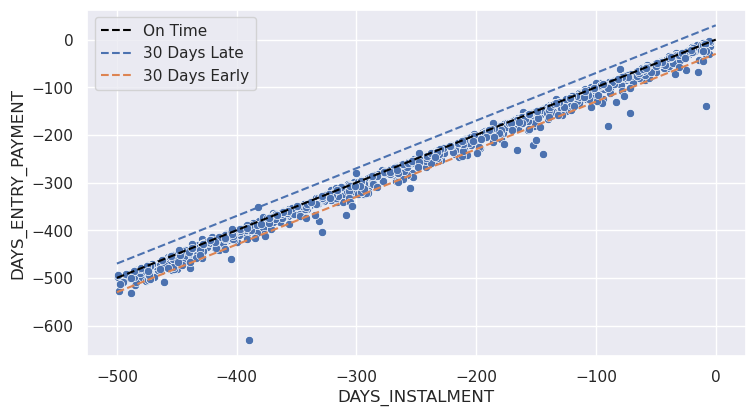

In [103]:
fig_days_late, ax_days_late = plt.subplots(figsize=BASE_FIG_SIZE)
x = np.linspace(-500, 0)
sns.scatterplot(
    y=installments_payments.filter(pl.col("DAYS_INSTALMENT") > -500)[
        "DAYS_ENTRY_PAYMENT"
    ].sample(1000, seed=1),
    x=installments_payments.filter(pl.col("DAYS_INSTALMENT") > -500)[
        "DAYS_INSTALMENT"
    ].sample(1000, seed=1),
    ax=ax_days_late,
)
sns.lineplot(x=x, y=x, linestyle="--", label="On Time", color="black", ax=ax_days_late)
sns.lineplot(x=x, y=x + 30, linestyle="--", label="30 Days Late", ax=ax_days_late)
sns.lineplot(x=x, y=x - 30, linestyle="--", label="30 Days Early", ax=ax_days_late)
plt.show()

<Axes: xlabel='AMT_INSTALMENT', ylabel='AMT_PAYMENT'>

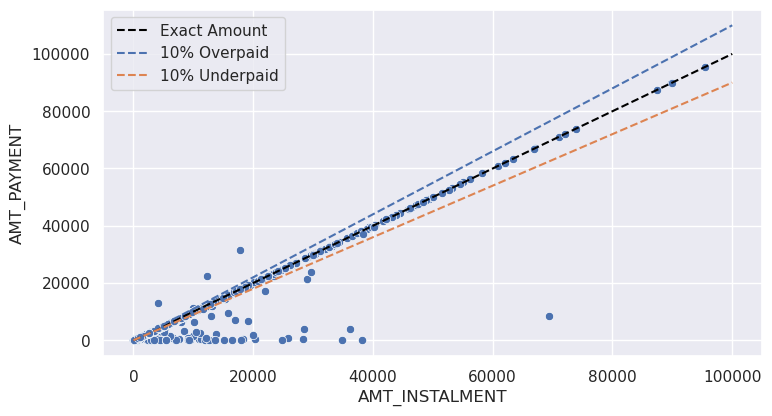

In [113]:
fig_days_late, ax_days_late = plt.subplots(figsize=BASE_FIG_SIZE)
x_inst = np.linspace(0, 100000)
sns.scatterplot(
    y=installments_payments.filter(pl.col("AMT_INSTALMENT") < 100000)[
        "AMT_PAYMENT"
    ].sample(1000, seed=1),
    x=installments_payments.filter(pl.col("AMT_INSTALMENT") < 100000)[
        "AMT_INSTALMENT"
    ].sample(1000, seed=1),
    ax=ax_days_late,
)
sns.lineplot(x=x_inst, y=x_inst, linestyle="--", label="Exact Amount", color="black", ax=ax_days_late)
sns.lineplot(x=x_inst, y=x_inst + x_inst*0.1, linestyle="--", label="10% Overpaid", ax=ax_days_late)
sns.lineplot(x=x_inst, y=x_inst - x_inst*0.1, linestyle="--", label="10% Underpaid", ax=ax_days_late)